In [ ]:
dir_folder = "/content/drive/MyDrive/comp-448-HW1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters.rank import enhance_contrast
from skimage import feature
import skimage
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max

#Image loading and preprocess 
###### *(for cell images)*

In [ ]:
cell_img_files = glob.glob(dir_folder + "/data/im*.jpg")
cell_truth_files = glob.glob(dir_folder + "/data/im*_gold_cells.txt")
mask_truth_files = glob.glob(dir_folder + "/data/im*_gold_mask.txt")

In [ ]:
cell_truth_files

['/content/drive/MyDrive/comp-448-HW1/data/im1_gold_cells.txt',
 '/content/drive/MyDrive/comp-448-HW1/data/im2_gold_cells.txt',
 '/content/drive/MyDrive/comp-448-HW1/data/im3_gold_cells.txt']

In [ ]:
#3 channel cell images
cell_imgs = [cv2.imread(f) for f in cell_img_files]

#binary ground truth files for foreground
mask_truth_imgs = [np.loadtxt(f) for f in mask_truth_files] 

#*255 version of foreground ground truths for visualization
mask_truth_vis = [np.loadtxt(f)*255 for f in mask_truth_files]

#truth files for cells
cell_truth_imgs = [np.loadtxt(f) for f in cell_truth_files] 

In [ ]:
#turn grayscale + apply gaussian blur
def preprocess(img): 
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_copy = gray_img.copy()
  gray_copy = cv2.GaussianBlur(gray_copy, (5,5),0)
  #plt.imshow(gray_copy, cmap='gray')
  return gray_copy

In [ ]:
preprocessed = [preprocess(img) for img in cell_imgs]

#Images after preprocess

<ipython-input-19-6f883a41b8e4>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_truth = np.vstack((l for l in left_imgs))
<ipython-input-19-6f883a41b8e4>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_img = np.vstack((r for r in right_imgs))


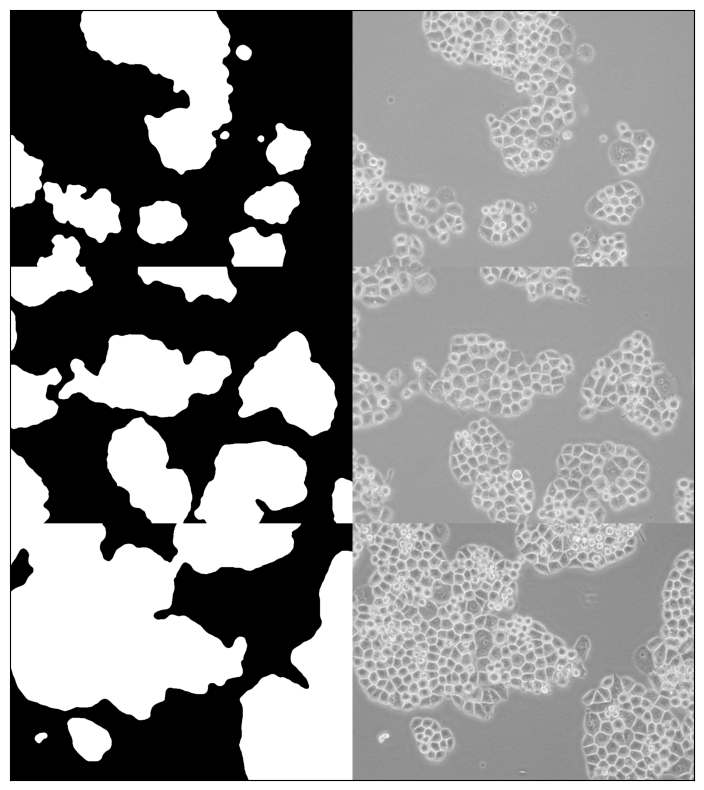

In [ ]:
def stacked_show(left_imgs, right_imgs):
  stacked_truth = np.vstack((l for l in left_imgs))
  stacked_img = np.vstack((r for r in right_imgs))

  plt.figure(figsize=(50,10))
  plt.xticks([]),plt.yticks([])
  plt.imshow(np.hstack((stacked_truth,stacked_img)), cmap='gray')

stacked_show(mask_truth_vis, preprocessed)

#Part 1: Obtaining foreground mask

In [ ]:
def obtainForeground(img):

    #otsu thresholding
    _, thresh = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    #invertion for foreground to be white
    thresh = 1 - thresh
    
    #closing iteratively with diff sized kernels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations = 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations =5)

    #opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations = 6)
    
    return img

foregrounds = [obtainForeground(img) for img in preprocessed]

In [ ]:
#make a grid of the results, concat imgs
def part1_performance(foreground, ground_truth):
  TP = np.sum(np.logical_and(foreground,ground_truth))
  FP = np.sum(np.logical_and(foreground,1 - ground_truth)) #ground neg, result pos
  FN = np.sum(np.logical_and(1 - foreground,ground_truth))

  precision = TP / (TP+FP)
  recall = TP / (TP + FN)
  f_score = TP / (TP + (1/2 *(FP + FN)))
  return precision, recall, f_score

### Performance metric results of part 1

In [ ]:
for i in range(len(foregrounds)):
  p, r, f = part1_performance(foregrounds[i], mask_truth_imgs[i])
  print("Performance for img no", i+1)
  print("Precision: %0.2f" % p)
  print("Recall: %0.2f" % r)
  print("F-score: %0.2f" % f, "\n")

Performance for img no 1
Precision: 0.92
Recall: 0.96
F-score: 0.94 

Performance for img no 2
Precision: 0.95
Recall: 0.97
F-score: 0.96 

Performance for img no 3
Precision: 0.98
Recall: 0.97
F-score: 0.97 



### Visualized results of foreground extraction

<ipython-input-19-6f883a41b8e4>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_truth = np.vstack((l for l in left_imgs))
<ipython-input-19-6f883a41b8e4>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_img = np.vstack((r for r in right_imgs))


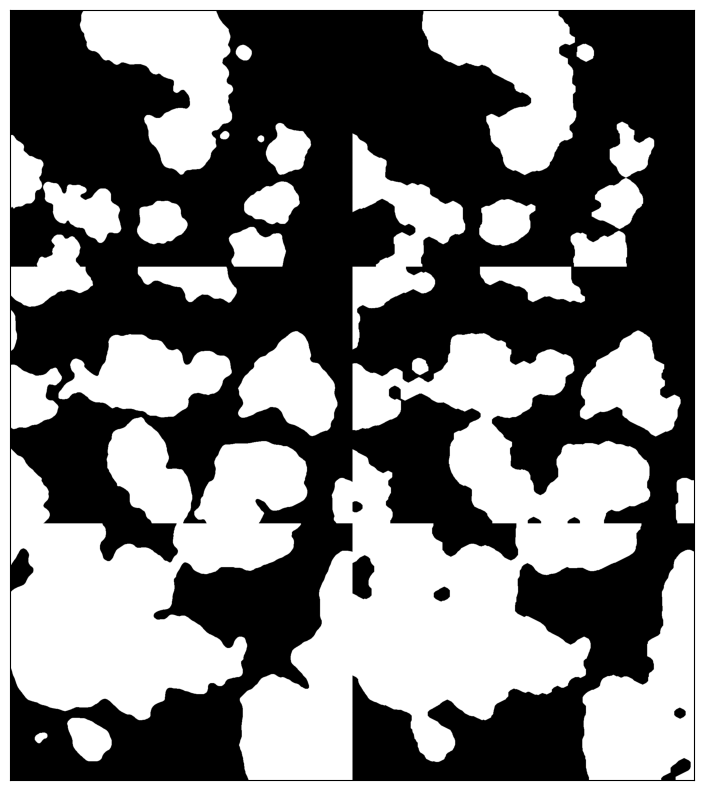

In [ ]:
stacked_show(mask_truth_imgs, foregrounds)

#Part 2: Finding cell locations

In [ ]:
def findCellLocations(orig, foreground):
    #get inside pixels of the cells to distance transform to edge
    a = cv2.GaussianBlur(enhance_contrast(orig, disk(10)),(5,5),0)
    a[a > 180] = 255
    a[a < 180] = 0

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    a = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel, iterations =1)
 
    inside = 255 - a

    #distance transforms to the edges from inside of the cells
    #default calculates to nearest non-zero
    dist = cv2.distanceTransform(inside, cv2.DIST_L2, 0)
  
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    c = peak_local_max(dist, min_distance=12)

    #filter only foreground
    c = c[foreground[c[:,0], c[:,1]] == 255]
    return c


def show_locations(img, coords):
   plt.plot(coords[:,1], coords[:,0], 'ro', markersize=3)
   plt.imshow(img, cmap = "gray")

#calculate for all 3 imgs
coords = [findCellLocations(preprocessed[i], foregrounds[i]*255) for i in range(len(preprocessed))]

### Performance metric results of part 2



In [ ]:
def part2_performance(coor, ground_truth):

  TP, FP, FN = 0, 0, 0
  checked = [] #contains ids of cells already checked

  for location in coor:
    if ground_truth[location[0]][location[1]] == 0:
      FP += 1
    elif ground_truth[location[0]][location[1]] in checked:
      FP += 1
    else:
      TP += 1
      checked.append(ground_truth[location[0]][location[1]])
    
  for row in range(len(ground_truth)):
    for col in range(len(ground_truth[row])):
      if ground_truth[row][col] != 0:
        if ground_truth[row][col] not in checked:
          FN += 1
          checked.append(ground_truth[row][col])

  precision = TP / (TP+FP)
  recall = TP / (TP + FN)
  f_score = TP / (TP + (1/2 *(FP + FN)))

  return precision, recall, f_score

In [ ]:
for i in range(len(coords)):
  p, r, f = part2_performance(coords[i], cell_truth_imgs[i])
  print("Performance for img no", i+1)
  print("Precision: %0.2f" % p)
  print("Recall: %0.2f" % r)
  print("F-score: %0.2f" % f, "\n")

Performance for img no 1
Precision: 0.89
Recall: 0.86
F-score: 0.87 

Performance for img no 2
Precision: 0.91
Recall: 0.90
F-score: 0.90 

Performance for img no 3
Precision: 0.88
Recall: 0.84
F-score: 0.86 



### Visualized results of finding cell locations

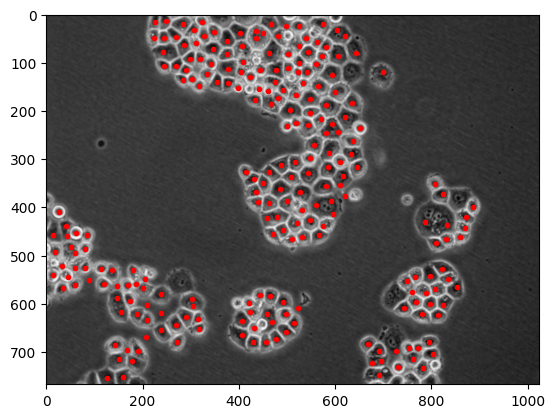

In [ ]:
show_locations(preprocessed[0], coords[0])

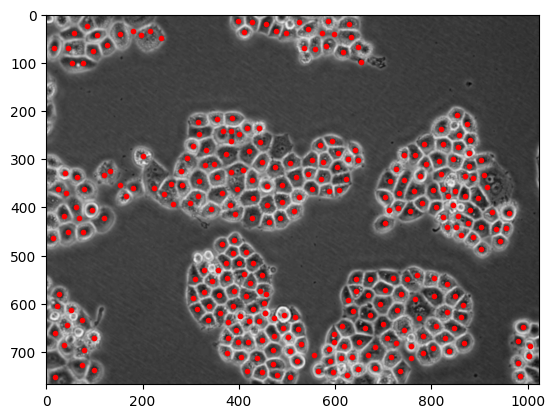

In [ ]:
show_locations(preprocessed[1], coords[1])

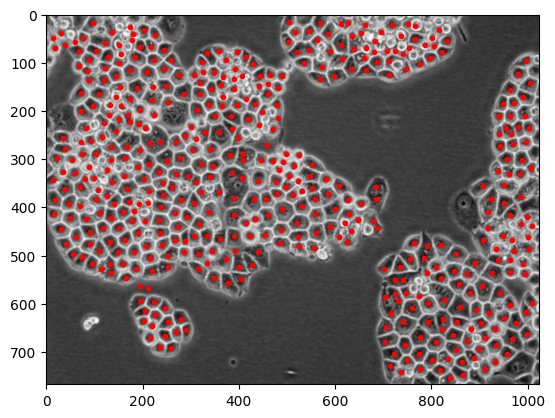

In [ ]:
show_locations(preprocessed[2], coords[2])

#Part 3: Find cell boundries

In [ ]:
import math

def marking_function(img, neighbor_x, neighbor_y, thresh):
  return img[neighbor_x][neighbor_y]> thresh

def regionGrow(img,coor,thresh):
    height, weight = img.shape
    seg_map = np.zeros(img.shape) ##seedMark
    seedList = []
    visited = {}

    for id, seed in enumerate(coor):
      seedList.append((id+1,seed,seed)) #id, coordinate of the point, coordinate of the original seed
    neighbor_offsets = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])

    while(len(seedList)>0):
        id, currentPoint, originalSeed = seedList.pop(0)
        visited[(currentPoint[0],currentPoint[1])] = 1
        neighbors = currentPoint + neighbor_offsets
        seg_map[currentPoint[0],currentPoint[1]] = id
        for i in range(4):
            tempX = neighbors[i,0]
            tempY = neighbors[i,1]
            distance = math.sqrt((originalSeed[0] - tempX)**2 + (originalSeed[1] - tempY)**2)
            temp = (tempX,tempY)
            if temp in visited:
                continue
            if distance > 20:
                continue
            if tempX < 0 or tempY < 0 or tempX >= height or tempY >= weight:
                continue
            mark = marking_function(img, tempX, tempY, thresh)
            if (mark or distance < 8) and seg_map[tempX,tempY] == 0:
                seg_map[tempX,tempY] = id
                seedList.append((id,[tempX,tempY],originalSeed))
                temp = (tempX,tempY)
    
    #plt.imshow(seg_map,cmap="gray")
    return seg_map

In [ ]:
def process_for_regionGrow(img):
  HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  V = HSV[:, :, 2]
  
  # Threshold all the very bright pixels
  bw = 255*np.uint8(V < 200)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  dilated = cv2.dilate(bw, kernel, iterations=2)

  return dilated

In [ ]:
processed_for_regionGrow = [process_for_regionGrow(img) for img in cell_imgs]
boundries = [regionGrow(processed_for_regionGrow[i], coords[i], 1) for i in range(len(processed_for_regionGrow))]

### Performance metric results of part 3

In [ ]:
def calculate_iou(seg1, seg2, thresh):
    # Find unique IDs in both segmentation images
    ids1 = np.unique(seg1)[1:]  # exclude background label 0
    ids2 = np.unique(seg2)[1:]
    
    # Initialize IoU matrix
    iou = np.zeros((len(ids1), len(ids2)))
    
    # Calculate IoU for all object pairs
    for i, id1 in enumerate(ids1):
        for j, id2 in enumerate(ids2):
            # Get binary masks for each object
            mask1 = (seg1 == id1)
            mask2 = (seg2 == id2)
            
            # Calculate intersection and union
            intersection = np.logical_and(mask1, mask2).sum()
            union = np.logical_or(mask1, mask2).sum()
            
            # Calculate IoU
            if union == 0:
                iou[i, j] = 0
            else:
                iou[i, j] = intersection / union

    TP, FP, FN = 0, 0, 0
    counted = [] #contains ids of cells already counted

    for i, id1 in enumerate(ids1):
      max = np.max(iou[i])
      index = np.where(iou[i] == max)[0][0]

      if ids2[index] not in counted:
        if max > thresh:
          TP += 1
          counted.append(ids2[index])
        else:
          FP += 1
      else:
        FP += 1

    for i, id2 in enumerate(ids2):
      if id2 not in counted:
        FN += 1

    precision = TP / (TP+FP)
    recall = TP / (TP + FN)
    f_score = TP / (TP + (1/2 *(FP + FN)))

    return precision, recall, f_score


def calculate_dice(seg1, seg2):
    # Find unique IDs in segmentation images
    ids1 = np.unique(seg1)[1:-1]  # exclude background label 0
    ids2 = np.unique(seg2)[1:-1]  # exclude background label 0
    #print(ids1)
    #print(ids2)

    # Initialize Dice array
    dice1 = np.zeros(len(ids1))
    dice2 = np.zeros(len(ids2))

    # Calculate Dice for each object in the first image
    for i, id1 in enumerate(ids1):
        # Get binary masks for each object

        mask1 = (seg1 == id1)
        masks2 = [(seg2 == id2) for id2 in ids2]
        
        # Calculate Dice for each matching object in the second image
        dice_vals1 = []
        for mask2 in masks2:
          dice_vals1.append(2 * np.logical_and(mask1, mask2).sum() / (mask1.sum() + mask2.sum()))
        
        # Take maximum Dice value as object-level Dice
        if len(dice_vals1) == 0:
            dice1[i] = 0
        else:
            dice1[i] = max(dice_vals1)

    # Calculate Dice for each object in the second image
    for i, id2 in enumerate(ids2):
        # Get binary masks for each object
        mask2 = (seg2 == id2)
        masks1 = [(seg1 == id1) for id1 in np.unique(seg1)[1:]]
        
        # Calculate Dice for each matching object in the second image
        dice_vals2 = []
        for mask1 in masks1:
          dice_vals2.append(2 * np.logical_and(mask2, mask1).sum() / (mask2.sum() + mask1.sum()))
        
        # Take maximum Dice value as object-level Dice
        if len(dice_vals2) == 0:
            dice2[i] = 0
        else:
            dice2[i] = max(dice_vals2)
    
    weighted_avg_dice1 = 0
    weighted_avg_dice2 = 0

    total_1 = (seg1 != 0).sum()
    total_2 = (seg2 != 0).sum()

    for i, id1 in enumerate(ids1):
      weighted_avg_dice1 += ( (seg1 == id1).sum() / total_1 ) * dice1[i]

    for i, id2 in enumerate(ids2):
      weighted_avg_dice2 += ( (seg2 == id2).sum() / total_2 ) * dice2[i]

    score = (weighted_avg_dice1 + weighted_avg_dice2) / 2
    
    return score

def part3_performance(segs, ground_truths, threshes):

  for i in range(len(threshes)):
    print("IoU for threshold  = %0.2f" % threshes[i], "\n")
    for k in range(len(segs)):
      p, r, f = calculate_iou(segs[k], ground_truths[k], threshes[i])
      print("Performance for img no", k+1)
      print("Precision: %0.2f" % p)
      print("Recall: %0.2f" % r)
      print("F-score: %0.2f" % f, "\n")

  return None


In [ ]:
part3_performance(boundries, cell_truth_imgs, [0.5, 0.75, 0.9] )

IoU for threshold  = 0.50 

Performance for img no 1
Precision: 0.73
Recall: 0.71
F-score: 0.72 

Performance for img no 2
Precision: 0.82
Recall: 0.80
F-score: 0.81 

Performance for img no 3
Precision: 0.77
Recall: 0.73
F-score: 0.75 

IoU for threshold  = 0.75 

Performance for img no 1
Precision: 0.32
Recall: 0.31
F-score: 0.31 

Performance for img no 2
Precision: 0.36
Recall: 0.36
F-score: 0.36 

Performance for img no 3
Precision: 0.34
Recall: 0.32
F-score: 0.33 

IoU for threshold  = 0.90 

Performance for img no 1
Precision: 0.02
Recall: 0.02
F-score: 0.02 

Performance for img no 2
Precision: 0.01
Recall: 0.01
F-score: 0.01 

Performance for img no 3
Precision: 0.01
Recall: 0.01
F-score: 0.01 



<ipython-input-68-be3efa0cf446>:69: RuntimeWarning: invalid value encountered in long_scalars
  dice_vals1 = np.array([2 * np.logical_and(mask1, mask2).sum() / (mask1.sum() + mask2.sum())
<ipython-input-68-be3efa0cf446>:85: RuntimeWarning: invalid value encountered in long_scalars
  dice_vals2 = np.array([2 * np.logical_and(mask2, mask1).sum() / (mask2.sum() + mask1.sum())


Dice index for img no 1
Dice: nan 

Dice index for img no 2
Dice: nan 



KeyboardInterrupt: ignored

In [ ]:
def part3_performance_dice(segs, ground_truths):
  for k in range(len(segs)):
      dice = calculate_dice(segs[k], ground_truths[k])
      print("Dice index for img no", k+1)
      print("Dice: %0.2f" % dice, "\n")
    
  return None

In [ ]:
part3_performance_dice(boundries, cell_truth_imgs)

Dice index for img no 1
Dice: 0.15 

Dice index for img no 2
Dice: 0.23 

Dice index for img no 3
Dice: 0.35 



### Visualized results of boundary detection

In [ ]:
def stacked_show_boundries(left_imgs, right_imgs):
  for x in left_imgs:
    x[x == 0] = np.nan 
  for x in right_imgs:
    x[x == 0] = np.nan

  stacked_l = np.vstack((l for l in left_imgs))
  stacked_r = np.vstack((r for r in right_imgs))

  plt.figure(figsize=(50,10))
  plt.rcParams['axes.facecolor'] = 'black'
  plt.xticks([]),plt.yticks([])
  plt.imshow(np.hstack((stacked_l,stacked_r)), cmap='prism')

<ipython-input-40-917384dc83d1>:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_l = np.vstack((l for l in left_imgs))
<ipython-input-40-917384dc83d1>:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_r = np.vstack((r for r in right_imgs))


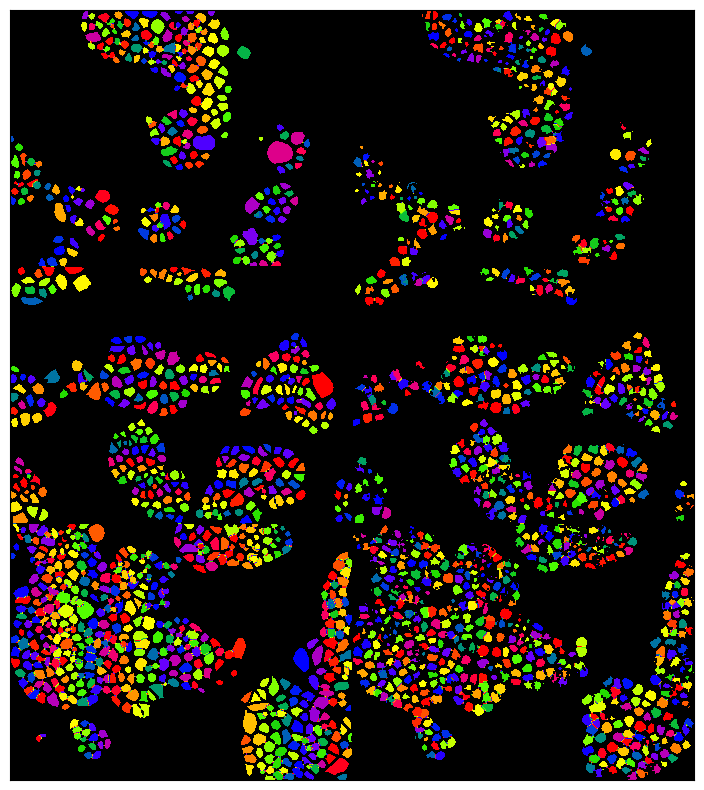

In [ ]:
stacked_show_boundries(cell_truth_imgs, boundries)

#Part 4: Segmentation of blood vessels in fundus photography images

In [ ]:
fundus_img_files = glob.glob(dir_folder + "/fundus/*.jpg")
fundus_truth_files = glob.glob(dir_folder + "/fundus/*.png")

In [ ]:
fundus_imgs = [cv2.imread(f) for f in fundus_img_files]
fundus_truth_imgs = [cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2GRAY) for f in fundus_truth_files]
fundus_truth_vis = [f*255 for f in fundus_truth_imgs]

In [ ]:
def preprocess_fundus(img): 
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_copy = gray_img.copy()
  kernel = np.ones((3,3),np.uint8)
  vessel_img = cv2.dilate(gray_copy,kernel,iterations = 1)
  vessel_img = cv2.GaussianBlur(vessel_img, (3,3),0)
  vessel_img = cv2.GaussianBlur(vessel_img, (3,3),0)
  #plt.imshow(gray_copy, cmap='gray')
  return vessel_img

In [ ]:
processed_fundus = [preprocess_fundus(i) for i in fundus_imgs]

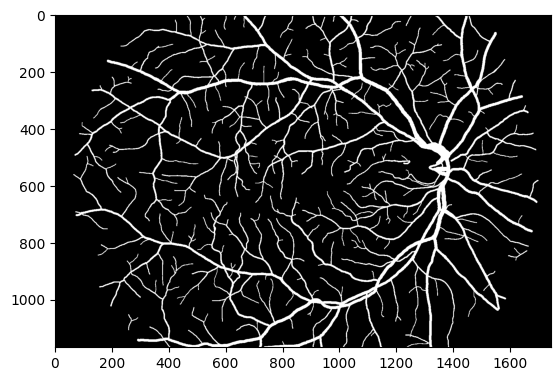

In [ ]:
plt.imshow(fundus_truth_vis[0],cmap="gray")

In [ ]:
def segmentFundus(img):
  #log filter
  log_kernel_big = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
  vessel_log = cv2.filter2D(img,-1, log_kernel_big)
  #plt.imshow(vessel_log,cmap="gray")

  #thresholding
  vessel_log[vessel_log>3] = 180
  vessel_log[vessel_log<3] = 0
  kernel = np.ones((2,2),np.uint8)
  
  #open + close
  a = cv2.morphologyEx(vessel_log, cv2.MORPH_OPEN, kernel, iterations =1)
  kernel = np.ones((3,3),np.uint8)
  b = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel, iterations =3)
  b = cv2.morphologyEx(b, cv2.MORPH_OPEN, kernel, iterations =1)
  guess_1 = b + vessel_log
  #plt.imshow(b+vessel_log, cmap="gray")
  
  denoised=cv2.fastNlMeansDenoising(guess_1,None,10,21)

  _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  inv = 255 - thresh

  out = skimage.morphology.area_opening(inv, area_threshold=5, connectivity=0)

  kernel = np.ones((2,2),np.uint8)
  denoised_dilate = cv2.dilate(out,kernel,iterations = 2)

  denoised3_dilate_out = skimage.morphology.area_opening(denoised_dilate, area_threshold=10, connectivity=1)
  out_open_2 = cv2.morphologyEx(denoised3_dilate_out, cv2.MORPH_CLOSE, kernel, iterations=4)

  kernel = np.ones((3,3),np.uint8)
  out_open = cv2.morphologyEx(denoised3_dilate_out, cv2.MORPH_OPEN, kernel, iterations=1)
  out_open = skimage.morphology.area_opening(out_open, area_threshold=120, connectivity=2)

  kernel = np.ones((3,3),np.uint8)
  out_open_2 = cv2.morphologyEx(out_open, cv2.MORPH_OPEN, kernel, iterations=1)
  out_open_2 = cv2.morphologyEx(out_open_2, cv2.MORPH_CLOSE, kernel, iterations=4)

  return out_open_2


In [ ]:
segmented = [segmentFundus(f) for f in processed_fundus]

<ipython-input-19-6f883a41b8e4>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_truth = np.vstack((l for l in left_imgs))
<ipython-input-19-6f883a41b8e4>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_img = np.vstack((r for r in right_imgs))


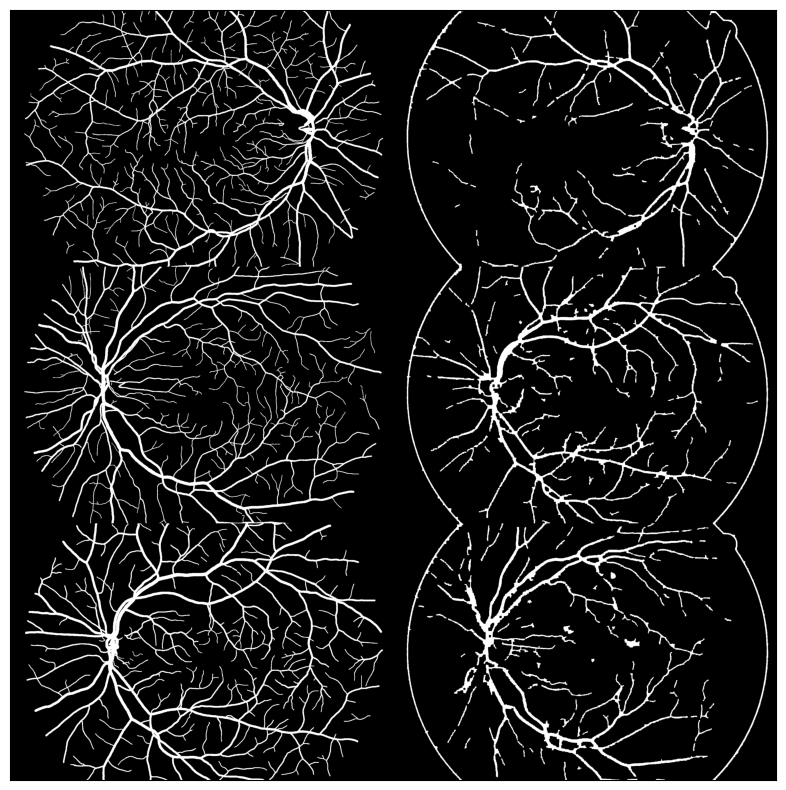

In [ ]:
stacked_show(fundus_truth_vis, segmented)

In [ ]:
for i in range(len(segmented)):
  p, r, f = part1_performance(segmented[i], fundus_truth_vis[i])
  print("Performance for img no", i+1)
  print("Precision: %0.2f" % p)
  print("Recall: %0.2f" % r)
  print("F-score: %0.2f" % f, "\n")

Performance for img no 1
Precision: 0.41
Recall: 0.29
F-score: 0.34 

Performance for img no 2
Precision: 0.12
Recall: 0.10
F-score: 0.11 

Performance for img no 3
Precision: 0.13
Recall: 0.10
F-score: 0.11 

